In [1]:
from collections import Counter
import numpy as np
from visualize_events.snomed import *
from visualize_events.data import *
from visualize_events.algorithms import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pydot
import networkx as nx
import numpy as np
from networkx.drawing.nx_agraph import graphviz_layout
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
import plotly.graph_objects as go
import plotly
import plotly.express as px
from shapely.ops import voronoi_diagram
from shapely.geometry import MultiPoint, Polygon, Point
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import Voronoi, voronoi_plot_2d
from plotly.subplots import make_subplots
import cvxopt
from hierarchy_layout import hierarchy_pos


import re
def label_name(label):
#     m = re.search(r'(\w*)[(].*[)]', label)
#     return m.group(0)
    return label[:label.index('(')]

def label_type(label):
    return label[label.index('(')+1:-1]


C:\Users\Sean McCarren\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Sean McCarren\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\Sean McCarren\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [41]:
T = load_dag()
print(len(T))
preds = get_predictions(861)
T_P = T.set_predictions(preds, aggregate='sum+unique')
# T = T.compact_preds()

assert T_P.nodes[263703002].pred_agg > 0
assert T_P.root.pred_agg > 0
# draw_nodes = nodes
# draw_nodes = representative(T_P, 50, score=lambda w, d: w * 1/(1.9**d))
# draw_nodes = representative(T_P, N, score=lambda w, d: w * 1/(1+d))
# draw_nodes = greedy_plus(T_P, 20)
cov = CoverageDistance(T, func=np.sqrt, only_leafs=True)
cov = CoverageDistance(T, func=lambda x : np.power(x, 1.5), only_leafs=True)
# cov = CoverageDistance(T, func=lambda x: 1 + np.log(x), only_leafs=False)
# cov = CoverageDistance(T, func=lambda x: 1 + np.log(x), only_leafs=True)
draw_nodes = cov.greedy(T_P, 10)
# draw_nodes = representative(T_P, 30)
# T_P.aggregate_pred('sum+unique')
assert draw_nodes[0].pred_agg > 0
summary = T_P.summary_graph(draw_nodes, copy_pred=True, single_source=False, discard_singles=False)
assert draw_nodes[0].pred_agg > 0
if summary.root:
    assert summary.root.pred == T_P.root.pred
    assert summary.root.pred_agg == T_P.root.pred_agg
    assert summary.root.pred_agg > 0
print(len(summary))

for n in summary.nodes.values():
    n.pred = n.pred_agg


7 predictions not found


356172
Initialization complete.
Initialization complete.
10


In [42]:
summary.attr_label()

In [53]:
nodes = list(summary.nodes.values())
ws = [n.pred_agg for n in nodes]
order = np.argsort(ws)

fig = go.Figure(go.Bar(
        x=[nodes[o].pred_agg for o in order],
        y=[nodes[o].label for o in order],
        orientation='h',
        name='frequency'))

fig.show() PUT BAR CHART TO MOTIVATE OTHER TABLE

In [62]:
for node in nodes:
    f_node = T.nodes[node.name]
    print(f_node.label)

None
None
None
None
None
None
None
None
None
None


# Basic visualization

computed pos


(-0.027885805197100943,
 1.0489469431046239,
 -3.5700000000000007,
 0.17000000000000004)

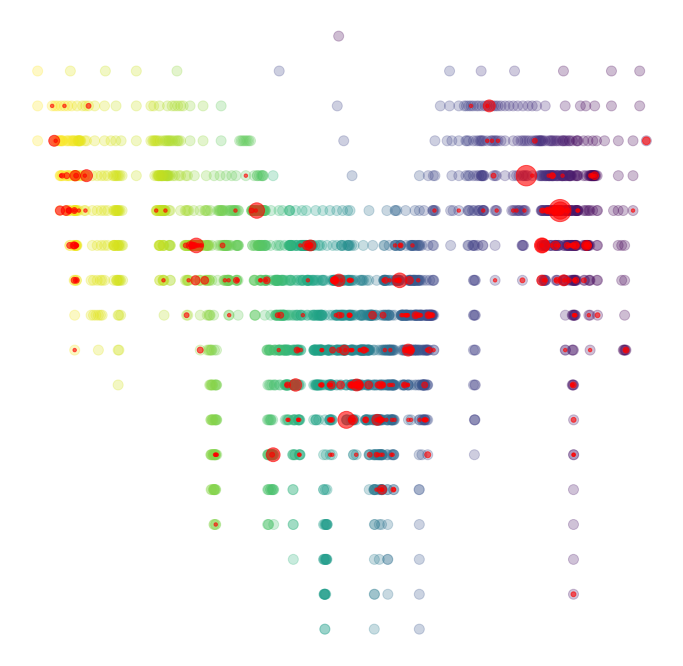

In [58]:
tree = T_P

c = 9
def l(t):
#     t = label_name(t)[:-1]
    split = t.split(' ')
    ress = []
    res = ''
    for item in split:
        res += ' ' + item
        if len(res) > 10:
            ress.append(res[1:])
            res = ''
    if len(res) > 0:
        ress.append(res[1:])
    joined = '\n'.join(ress)
    return joined

tree.attr_label()

edges = []
edges_to_add_later = []
add_nodes = set()
coloring = dict()
for i, node in enumerate(tree.traverse(raise_on_visited=False, yield_visited=False, yield_first_visit=True)):
    coloring[node.name] = i / (len(tree) - 1)
    if len(add_nodes) == 0: # root
        add_nodes.add(node)
    if node in add_nodes:
        for child in node.children:
            if child not in add_nodes:
                add_nodes.add(child)
                edges.append((node.name, child.name))
            else:
                edges_to_add_later.append((node.name, child.name))

g = nx.DiGraph()
g.add_edges_from(edges)

assert nx.is_tree(g)

pos = hierarchy_pos(g)

g.add_edges_from(edges_to_add_later)

selected_labels = {node.name: l(node.label) for node in tree.nodes.values() if node.name in summary.nodes.keys()}

print("computed pos")
fig = plt.figure(figsize=(12,12))
ax = fig.gca()
# fig, axs = plt.subplots(figsize=(30,15), ncols=2)

# nx.draw_networkx_edges(g, pos, ax=ax, arrowstyle='-', alpha=0.1)
nx.draw_networkx_nodes(g, pos, ax=ax, alpha=0.26, node_size=100, cmap='viridis', node_color=[coloring[n] for n in list(g)])
# nx.draw_networkx(g, pos, ax=axs[1], nodelist=selected_labels.keys(), edgelist=[], with_labels=False, alpha=1.0, node_size=100, cmap='viridis', node_color=[coloring[n] for n in selected_labels.keys()]);
# nx.draw_networkx_labels(g, pos, ax=axs[1], labels=selected_labels);
# fig


nx.draw_networkx_nodes(g, pos, ax=ax, nodelist=[n.name for n in tree.nodes.values() if (n.pred is not None and n.pred != 0)], alpha=0.6, node_size=[n.pred * 5000 for n in tree.nodes.values()  if (n.pred is not None and n.pred != 0)], cmap='viridis', node_color="red")

plt.axis('off')
# plt.savefig('full_tree_and_preds.pdf', bbox_inches='tight', pad_inches = 0)


In [57]:

### Additionally drawing summary nodes around the plot!

(-0.7, 1.71, -3.817022023446691, 0.1817629534974615)

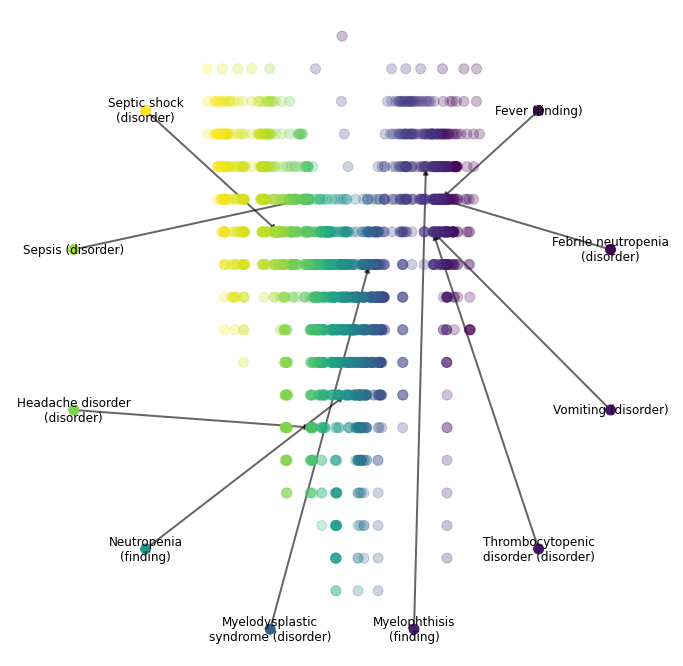

In [59]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca()
# nx.draw_networkx_edges(g, pos, ax=ax, arrowstyle='-', alpha=0.03)
nx.draw_networkx_nodes(g, pos, ax=ax, alpha=0.26, node_size=100, cmap='viridis', node_color=[coloring[n] for n in list(g)])

mid = pos[409623005]
furthest = pos[404684003]

r = np.sqrt((mid[0] - furthest[0]) ** 2 + (mid[1] - furthest[1]) ** 2) * 1.4

ang_start = 3/4 * np.pi
ang_end = (2 + 1/4) * np.pi

diff = (ang_end - ang_start) / (len(selected_labels) - 1)

colors = [coloring[n] for n in selected_labels.keys()]
order = np.argsort(colors)
# order = [14, 18, 16, 13, 12,  3,  4, 10, 0, 17,  9, 11,  7,  2, 5,  6, 1, 15,  8, 19] # of their method
# order = [5, 12, 17, 14, 11, 10, 3, 13,  4, 19, 15, 9, 7, 16,  0,  2,  6,  1,  8, 18] # of ours with log
# order = [5, 11, 16, 13, 19, 10,  9, 4, 12,  18, 14, 8, 7, 15, 0,  2, 3, 6,  1, 17] # of ours with sqrt

label_pos = dict()
for i, o in enumerate(order):
    name, label = list(selected_labels.items())[o]
    ang = ang_start + diff * i
    loc = (mid[0] - np.cos(ang), mid[1] + 1.9 * np.sin(ang) - 0.4)
    label_pos[name] = loc



for name, label in selected_labels.items():
    arrow = mpl.patches.FancyArrowPatch(posA=label_pos[name], posB=pos[name], alpha=.6, arrowstyle='-|>', color="black", mutation_scale=10, linewidth=2,)
    ax.add_patch(arrow)
    
nx.draw_networkx(g, label_pos, ax=ax, nodelist=selected_labels.keys(), edgelist=[], with_labels=False, alpha=1.0, node_size=100, cmap='viridis', node_color=[coloring[n] for n in selected_labels.keys()]);
nx.draw_networkx_labels(g, label_pos, ax=ax, labels=selected_labels);
ax.set_xlim((-0.7, 1.71))
plt.axis('off')
# plt.savefig('20_summary_our_method_log.pdf', bbox_inches='tight', pad_inches = 0)


In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca()
for name, label in selected_labels.items():
    arrow = mpl.patches.FancyArrowPatch(posA=label_pos[name], posB=pos[name], alpha=.4, arrowstyle='-|>', color="black", mutation_scale=10, linewidth=3,)
    ax.add_patch(arrow)
    
nx.draw_networkx(g, label_pos, ax=ax, nodelist=selected_labels.keys(), edgelist=[], with_labels=False, alpha=1.0, node_size=100, cmap='viridis', node_color=[coloring[n] for n in selected_labels.keys()]);
nx.draw_networkx_labels(g, label_pos, ax=ax, labels=selected_labels);

ax.set_xlim((-0.7, 1.71))


In [ ]:
order

# Design 1

In [3]:
tree = T_P


tree.attr_label()
nodes = list(tree.nodes.values())
N = len(tree)
indx_P_nodes, P_nodes = [], []
for i, node in enumerate(nodes):
    if (node.pred is not None and node.pred != 0):
        indx_P_nodes.append(i)
        P_nodes.append(node)

N_points = len(P_nodes)
weights = [n.pred for n in P_nodes]

# ------- INITIAL POINT ASSIGNMENT --------
anc_store_dict = tree.get_ancestors()
anc_store = [anc_store_dict[n] for n in nodes]

dist = np.zeros((N, N))
for i, anc1 in enumerate(anc_store):
    for j, anc2 in enumerate(anc_store[i+1:], i+1):
#         common = anc1.intersection(anc2)
        diff = anc1.symmetric_difference(anc2)
        #d = 1/len(common)
#         d = 1/(sum(a.depth for a in common)+1)
        d = len(diff) / (len(anc1) + len(anc2))
        dist[i, j] = d
        dist[j, i] = d
dist = np.power(dist, 1.5)


similarity = dist[indx_P_nodes, :][:, indx_P_nodes]

tsne = TSNE(metric="precomputed",
            perplexity=30,
            early_exaggeration=10)
embedding = tsne.fit_transform(similarity)

scaler = MinMaxScaler(feature_range=(-0.95,0.95))
embedding = scaler.fit_transform(embedding)
embedding_original = embedding.copy()

Aiming to cover: 0.1983693045563529
That is 4.9592326139088225%


C:\Users\Sean McCarren\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Sean McCarren\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Sean McCarren\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


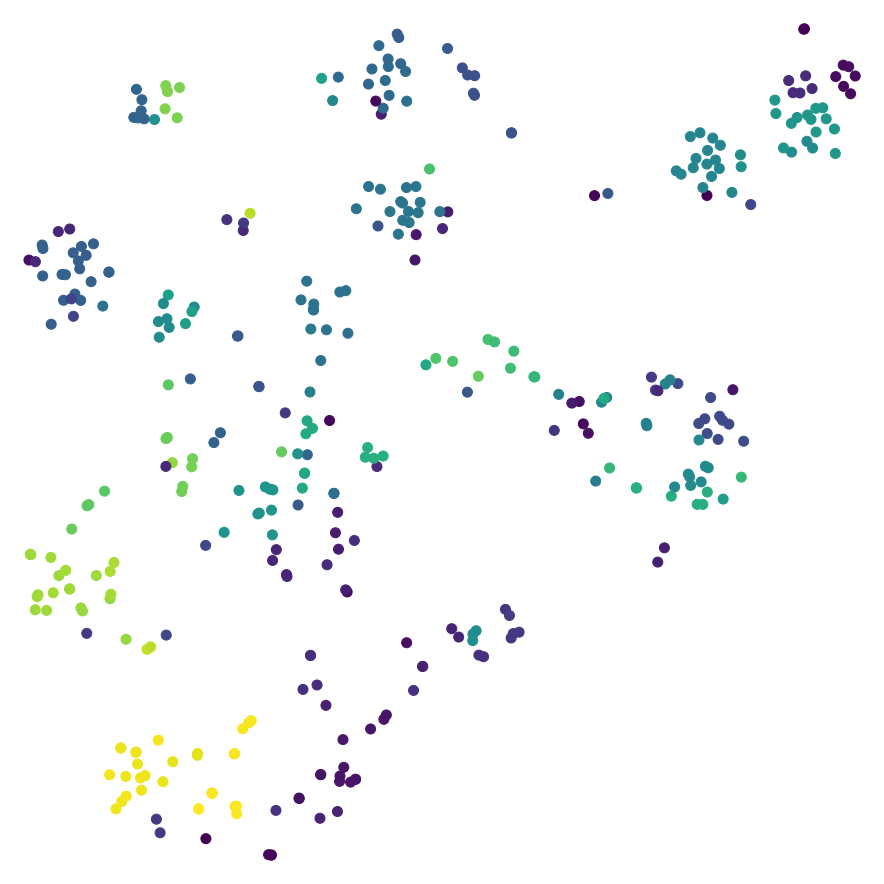

Covered area:


In [4]:
size = len(tree)
color = {node: i/size for i, node in enumerate(tree.traverse(yield_first_visit=True, raise_on_visited=False, yield_visited=False))}

plt.figure(figsize=(16,16))
ax = plt.gca()

plt.scatter(embedding_original[:, 0], embedding_original[:, 1], s=100, c=[color[n] for n in P_nodes])

ax.set_aspect('equal')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis('off')
plt.savefig('embedding.pdf', bbox_inches='tight', pad_inches = 0)
plt.show()
print("Covered area:")


Aiming to cover: 0.40991157074340095
That is 10.247789268585024%
     pcost       dcost       gap    pres   dres
 0: -1.7971e+02 -7.0525e+02  1e+04  3e+01  8e+00
 1: -1.9881e+02 -1.8433e+03  6e+03  1e+01  4e+00
 2: -1.3476e+02 -1.8458e+03  5e+03  1e+01  3e+00
 3: -1.2197e+02 -1.4284e+03  3e+03  6e+00  2e+00
 4: -1.7308e+02 -9.5710e+02  2e+03  2e+00  7e-01
 5: -2.2554e+02 -5.5703e+02  5e+02  5e-01  2e-01
 6: -2.3311e+02 -4.0747e+02  2e+02  2e-01  6e-02
 7: -2.3582e+02 -3.0900e+02  8e+01  5e-02  2e-02
 8: -2.3660e+02 -2.5615e+02  2e+01  9e-03  3e-03
 9: -2.3684e+02 -2.4239e+02  6e+00  7e-04  2e-04
10: -2.3690e+02 -2.3840e+02  1e+00  2e-15  6e-15
11: -2.3693e+02 -2.3729e+02  4e-01  2e-15  1e-15
12: -2.3694e+02 -2.3710e+02  2e-01  2e-15  2e-16
13: -2.3695e+02 -2.3700e+02  5e-02  2e-15  1e-16
14: -2.3695e+02 -2.3696e+02  1e-02  2e-15  1e-16
15: -2.3695e+02 -2.3695e+02  3e-03  2e-15  1e-16
16: -2.3695e+02 -2.3695e+02  5e-04  2e-15  2e-16
17: -2.3695e+02 -2.3695e+02  6e-05  2e-15  3e-16
Optim

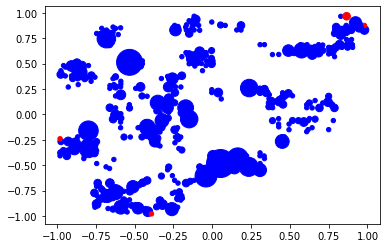

In [16]:

f = 0.2875#434
print("Aiming to cover: " + str(np.sum(np.square(np.sqrt(weights) * f * np.sqrt(2)))))
print("That is " + str(np.sum(np.square(np.sqrt(weights) * f * np.sqrt(2))) / 4 * 100) + "%")
assert N_points == len(embedding)

# variables xi's, yi's
P = 2 * np.eye(2 * N_points)
q = -  2 * np.concatenate((embedding[:, 0], embedding[:, 1])).reshape(-1, 1)


if False: # cost function depends on weights
    for i, w in enumerate(weights):
        P[i,i] *= w
        P[N_points + i, N_points + i] *= w
        q[i, 0] *= w
        q[N_points + i, 0] *= w

x_order = np.argsort(embedding[:, 0])
y_order = np.argsort(embedding[:, 1])

G = []
h = []

# constraint = np.zeros(2 * N_points)
# constraint[-1] = -1
# G.append(constraint)
# h.append(0)

for i in range(N_points - 1):
    xi = x_order[i]
    xi_plus_1 = x_order[i+1]
    constraint = np.zeros(2 * N_points)
    constraint[xi] = 1
    constraint[xi_plus_1] = -1
    G.append(constraint)
    h.append(0)
    
for i in range(N_points - 1):
    yi = y_order[i]
    yi_plus_1 = y_order[i+1]
    constraint = np.zeros(2 * N_points)
    constraint[N_points + yi] = 1
    constraint[N_points + yi_plus_1] = -1
    G.append(constraint)
    h.append(0)

factor = np.sqrt(2)
for (idx, coef, val) in (
    (x_order[0], -1, 1-factor*f*np.sqrt(weights[x_order[0]])), # -1 < x0 => -x0 <= 1
    (x_order[-1], 1, 1-factor*f*np.sqrt(weights[x_order[-1]])), # xl < 1 => xl <= 1
    (N_points + y_order[0], -1, 1-factor*f*np.sqrt(weights[y_order[0]])), # -1 < y0 => -y0 <= 1
    (N_points + y_order[-1], 1, 1-factor*f*np.sqrt(weights[y_order[-1]])), # yl < 1 => yl <= 1
):
    constraint = np.zeros(2 * N_points)
    constraint[idx] = coef
    G.append(constraint)
    h.append(val)

# for (idx, coef, w) in (
#     (x_order[0], -1, factor*np.sqrt(weights[x_order[0]])), # -1+fw < x0 => -x0+fw <= 1
#     (x_order[-1], 1, factor*np.sqrt(weights[x_order[-1]])), # xl < 1-fw => xl+fw <= 1
#     (N_points + y_order[0], -1, factor*np.sqrt(weights[y_order[0]])), # -1+fw < y0 => -y0+fw <= 1
#     (N_points + y_order[-1], 1, factor*np.sqrt(weights[y_order[-1]])), # yl < 1-fw => yl+fw <= 1
# ):
#     constraint = np.zeros(2 * N_points+1)
#     constraint[idx] = coef
#     constraint[-1] = w
#     G.append(constraint)
#     h.append(1)

    
x_order = x_order.tolist()
y_order = y_order.tolist()

def constrain(pi, pj):
    assert pi != pj
    # wi + wj <= dist_x + dist_y
    # -(dist_x + dist_y) <= -(wi + wj)f
    # -(dist_x + dist_y) + (wi + wj)f <= 0
#     pix, piy = embedding[pi].tolist()
#     pjx, pjy = embedding[pj].tolist()
    constraint = np.zeros(N_points * 2)
    if x_order.index(pi) < x_order.index(pj):
        # dist_x = pj - pi
        constraint[pi] = 1
        constraint[pj] = -1
    else:
        constraint[pi] = -1
        constraint[pj] = 1
    if y_order.index(pi) < y_order.index(pj):
        # dist_y = pj - pi
        constraint[N_points + pi] = 1
        constraint[N_points + pj] = -1
    else:
        constraint[N_points + pi] = -1
        constraint[N_points + pj] = 1

    w = -(np.sqrt(weights[pi]) + np.sqrt(weights[pj])) * f
#     constraint[-1] = np.sqrt(weights[pi]) + np.sqrt(weights[pj])
    
    G.append(constraint)
    h.append(w)

for dim in (0,1):
    while len(np.unique(embedding[:, dim])) != N_points:
        embedding[:, dim] += np.random.normal(scale=0.00001, size=N_points)
        print("Warning: duplicate coordinates. Randomly shifting coordinates a tiny bit.")
    
for pi in range(N_points):
    for pj in range(N_points):
        if pi == pj:
            continue
#         if pi < pj:
#             constrain(pi, pj)
#         continue
        if embedding[pi, 0] < embedding[pj, 0]:
            if embedding[pi, 1] < embedding[pj, 1]:
                one = (embedding[:, 0] > embedding[pi, 0]) & (embedding[:, 1] > embedding[pi, 1])
                two = (embedding[:, 0] < embedding[pj, 0]) & (embedding[:, 1] < embedding[pj, 1])
                if np.any(one & two):
                    continue
            elif embedding[pi, 1] > embedding[pj, 1]:
                one = (embedding[:, 0] > embedding[pi, 0]) & (embedding[:, 1] < embedding[pi, 1])
                two = (embedding[:, 0] < embedding[pj, 0]) & (embedding[:, 1] > embedding[pj, 1])
                if np.any(one & two):
                    continue
            else:
                raise ValueError()
            
        elif embedding[pi, 0] == embedding[pj, 0]:
            raise ValueError()
        else:
            continue
        constrain(pi, pj)
        
            
G = np.array(G).astype(np.double)
h = np.array(h).astype(np.double)

assert G.shape == (len(h), 2 * N_points )

P = P.astype(np.double)
q = q.astype(np.double)

assert P.shape == (2 * N_points , 2 * N_points )
assert q.shape == (2 * N_points , 1)

    
def cvxopt_solve_qp(P, q, G=None, h=None, A=None, b=None):
    P = .5 * (P + P.T)  # make sure P is symmetric
    args = [cvxopt.matrix(P), cvxopt.matrix(q)]
    if G is not None:
        args.extend([cvxopt.matrix(G), cvxopt.matrix(h)])
        if A is not None:
            args.extend([cvxopt.matrix(A), cvxopt.matrix(b)])
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    return np.array(sol['x']).reshape((P.shape[1],))

result = cvxopt_solve_qp(P, q, G=G, h=h)
embedding[:, 0] = result[:N_points]
embedding[:, 1] = result[N_points:]

plt.scatter(embedding[:, 0], embedding[:, 1], s=[8000*n.pred for n in P_nodes], c=['r' if i in (x_order[0], x_order[-1], y_order[0], y_order[-1]) else 'b' for i in range(N_points)])
plt.savefig('test.pdf')

print("Average displacement: "  + str(np.mean(np.linalg.norm(embedding_original - embedding, axis=1))))

In [17]:
plt.show()

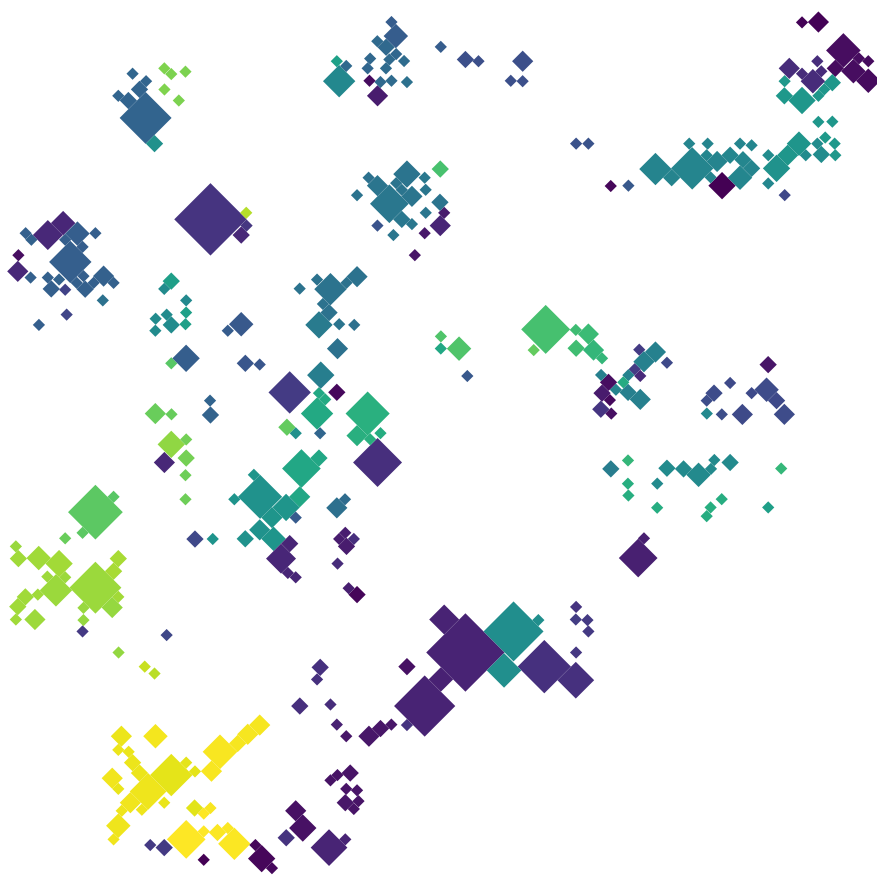

Covered area:


In [18]:
cmap = mpl.cm.get_cmap('viridis')

plt.figure(figsize=(16,16))
ax = plt.gca()
for emb, n in zip(embedding, P_nodes):
    rad = np.sqrt(n.pred) * f
    width = np.sqrt(2) * rad
    ax.add_patch(plt.Rectangle((emb[0] - rad, emb[1]), width, width, -45, fc=cmap(color[n])))
    if n.pred >= np.quantile(weights, 0.9) and False:
        ax.text(*emb.tolist(), label_name(n.label), verticalalignment='bottom', horizontalalignment='center')
        ax.text(*emb.tolist(), label_type(n.label), verticalalignment='top', horizontalalignment='center')
ax.set_aspect('equal')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis('off')
plt.savefig('orthogonal_problem.pdf', bbox_inches='tight', pad_inches = 0)
plt.show()
print("Covered area:")

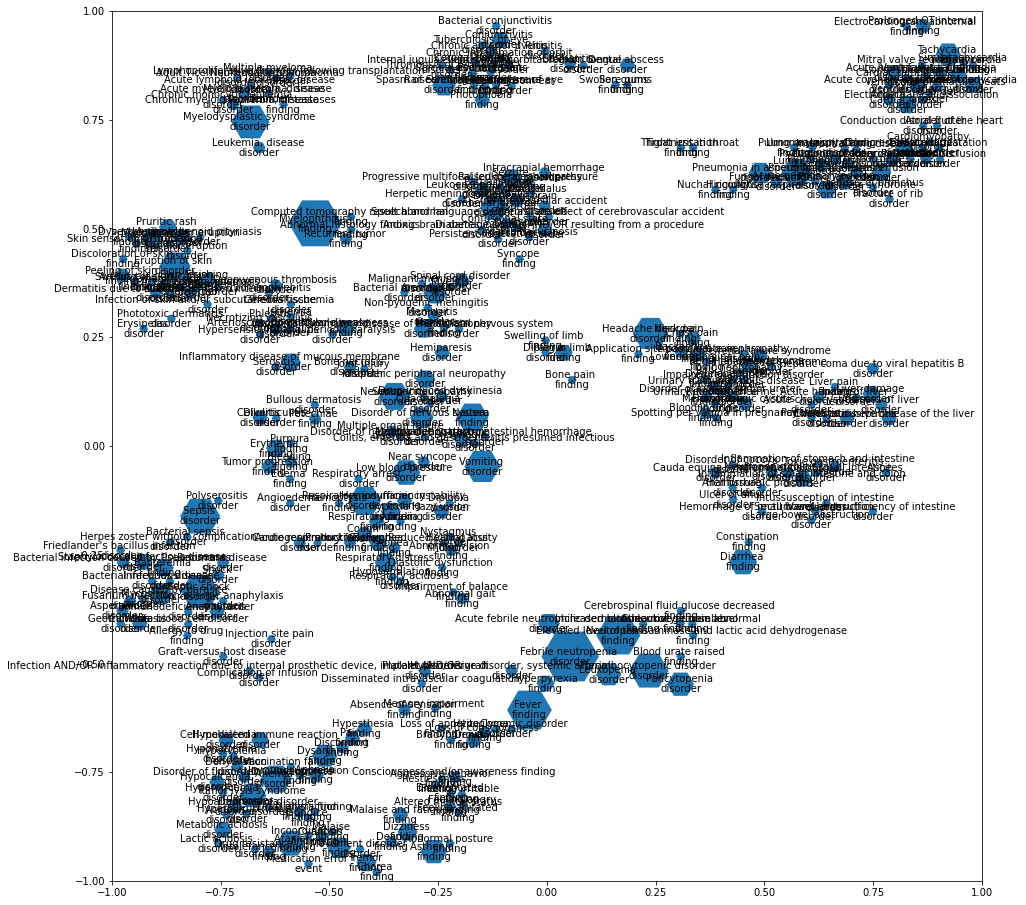

In [19]:
plt.figure(figsize=(16,16))
ax = plt.gca()
for emb, n in zip(embedding, P_nodes):
    rad = np.sqrt(n.pred) * f / np.sqrt(2)
    rad = rad / np.cos(15/180*np.pi)
    ax.add_patch(mpl.patches.RegularPolygon(emb, 6, rad, 30/180*np.pi))
    if n.pred >= np.quantile(weights, 0.):
        ax.text(*emb.tolist(), label_name(n.label), verticalalignment='bottom', horizontalalignment='center')
        ax.text(*emb.tolist(), label_type(n.label), verticalalignment='top', horizontalalignment='center')
ax.set_aspect('equal')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Deleted 100 from 70126 edges, added 108


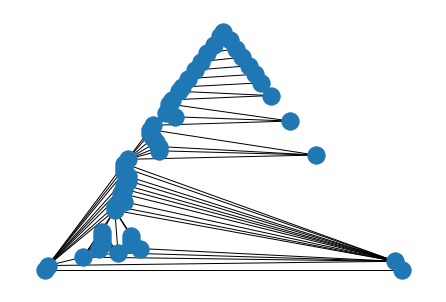

In [20]:
tree.add_parent_store()
from itertools import combinations

tree.descendant_pred()
pred_nodes = tree.root.preds
weights = dict()
for n in tree.nodes.values():
    if n is tree.root:
        continue
    for a, b in combinations(n.preds, 2):
        if id(a) > id(b):
            a, b = b, a
        w = weights.get((a, b), 0)
        weights[(a, b)] = w + 1 * n.depth
print(weights)

def nx_from_edge_weights(edge_weights):
    if isinstance(edge_weights, dict):
        edge_weights = edge_weights.items()
    G = nx.Graph()
    G.add_edges_from([(*key, {"weight": weight}) for key, weight in edge_weights])
    return G

# Could check if entire thing is planar or do binary/exponential search backwards
sort_weights = sorted(weights.items(), key=lambda x: x[1], reverse=True)
include = sort_weights[:4].copy()
g = nx_from_edge_weights(include)
deleted = 0
added = 4
for key, weight in sort_weights[4:]:
    g.add_edge(*key, weight=weight)
    is_planar, emb = nx.check_planarity(g)
    if not is_planar:
        g.remove_edge(*key)
        deleted += 1
        if deleted == 100:
            break
    else:
        added += 1
    
print(f"Deleted {deleted} from {len(weights)} edges, added {added}")
pos = nx.planar_layout(g)
nx.draw(g, pos=pos)

f = 0.45320303866709283
target_coverage = 1.6
Total movement 10.630904724497272
Total overlaps 1612
Total movement 0.719601658618716
Total overlaps 774


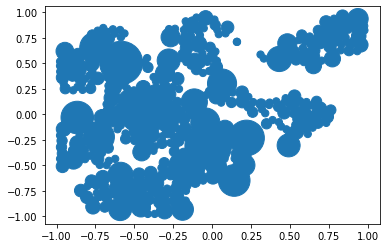

Total movement 0.6340063679153904
Total overlaps 734
Total movement 0.8585444289266327
Total overlaps 738


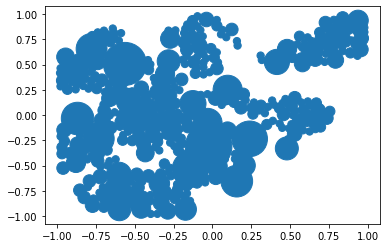

Total movement 0.4627730427599044
Total overlaps 692
Total movement 0.29581526651736656
Total overlaps 750


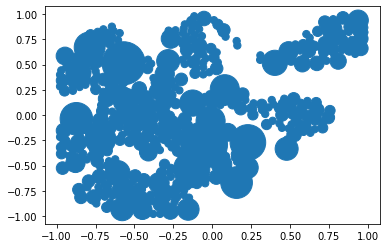

Total movement 0.6229009027359501
Total overlaps 726
Total movement 0.5738094277042639
Total overlaps 740


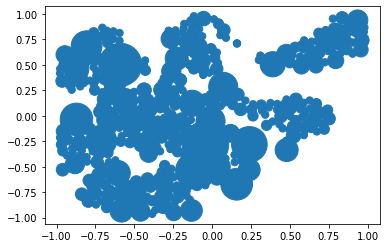

Total movement 0.6494194903322106
Total overlaps 724
Total movement 0.5145272869659838
Total overlaps 716


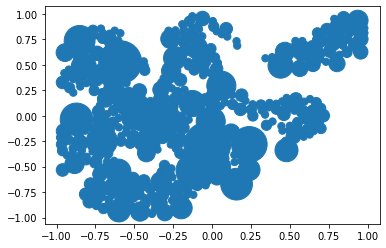

Total movement 0.4373884062140598
Total overlaps 704
Total movement 0.5944678210922579
Total overlaps 730


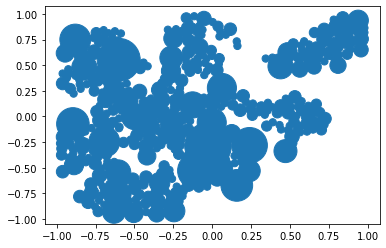

Total movement 0.4103413922566434
Total overlaps 722
Total movement 0.6343803042354235
Total overlaps 727


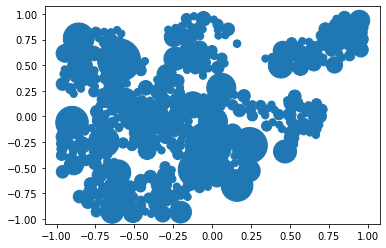

Total movement 0.5471876607593776
Total overlaps 708
Total movement 0.4940421493193953
Total overlaps 716


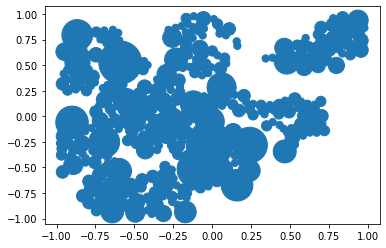

Total movement 0.391599200192713
Total overlaps 758
Total movement 0.27853879005096305
Total overlaps 718


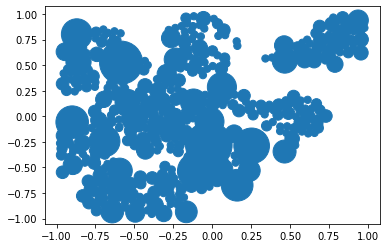

Started cooldown
Total movement 0.31504710744656084
Total overlaps 692
Total movement 0.004417330448351607
Total overlaps 622


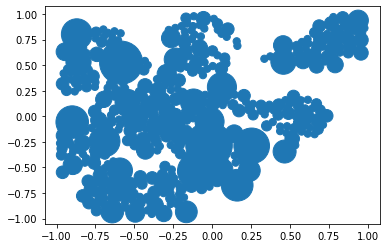

Exited cooldown
Inside: 100.0%
Final f=0.45320303866709283.
Occupied area1.6


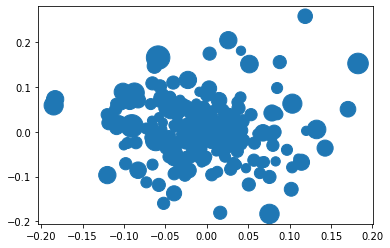

In [31]:
embedding = embedding_original.copy()
# ------- IMPROVING POINT ASSIGNMENT --------
max_movement = 0.05
epochs = 1000
cooldown_period = 100
cooldown = False
window_size = 500
verbose = 50

target_coverage = 0.4 * 4

weights = np.array([p.pred for p in P_nodes])

f = np.sqrt(target_coverage/(np.pi*np.sum(weights)))
print("f = " + str(f))
print("target_coverage = " + str(np.sum(np.power(f*np.sqrt(weights), 2)*np.pi)))
# f = 1.


radius = f * np.sqrt(weights)
radius_sum = np.tile(radius.reshape(-1, 1), (1, N_points)) + np.tile(radius.reshape(1, -1), (N_points, 1))

movements = np.zeros(epochs)

# distance_AB * f > np.sqrt(weightA) + np.sqrt(weightB) 
# cross_sum/distance < f
# for larger f, the distance_AB may be smaller
# for smaller f, the distance_AB must be larger
# maybe start with large f, and decrease it.

# move points away from eachother

for epoch in range(epochs):
    if (epoch+1) % 100 == 0:
        plt.scatter(embedding[:, 0], embedding[:, 1], s=[10000*(n.pred)/f for n in P_nodes])
        plt.show()

#     within = (embedding[:, 0] < 1) & (embedding[:, 0] > -1) & (embedding[:, 1] < 1) & (embedding[:, 1] > -1)
#     print(f"Inside: {np.mean(within) * 100}%")
    
#     pw = similarity
    recompute_pw = True
    while recompute_pw:
        recompute_pw = False
        pw = pairwise_distances(embedding)
        for i in range(N_points):
            pw[i,i] = np.inf
        min_pw = np.min(pw)
    #     print(f"Smallest pw: {min_pw}")
        indx_nonzero = (pw == 0).nonzero()
        for i, j in zip(*indx_nonzero):
            embedding[i] += np.random.randn(2) / 10000
            recompute_pw = True
        min_pw = np.min(pw)

    # move[x, y] = -(emb[x] - emb[y])
    move =  - (np.tile(embedding.reshape(N_points, 1, 2), (1, N_points, 1)) - np.tile(embedding.reshape(1, N_points, 2), (N_points, 1, 1)))
    
    # pairwise repelling    
    # overlap_dist = r_1 + r_2 - |emb[x] - emb[y]|
    # if overlap_dist > 0, F = move[x, y]/|emb[x] - emb[y]| * overlap_dist / 2
    pw_fix = pw.copy()
    pw_fix[range(N_points), range(N_points)] = 0
    overlap_dist = radius_sum - pw_fix
#     print(overlap_dist)
    overlapping = (overlap_dist > 0)
    overlapping[range(N_points), range(N_points)] = False
    N_overlaps = np.sum(overlapping)
    overlap_dist = overlap_dist * overlapping
    F_pw = - np.divide(overlap_dist, pw) * 0.5
    
    assert F_pw.shape == pw.shape

    F_pw = np.tile(F_pw.reshape(N_points, N_points, 1), (1, 1, 2)) * move
    F_pw = np.sum(F_pw, axis=1)
    # F_pw[x] = force vec of x

    # repelling from edges
    # direction: center, magnitude: ~ L5 norm ( not L2 so corners can get fuller )
    # also cut off repelling at certain ratio
    for dim in (0,1):
        for i in np.where(embedding[:, dim] - radius < -1)[0]:
            embedding[i, dim] - radius[i]
            F_pw[i, dim] += - 1 - embedding[i, dim] + radius[i]
        for i in np.where(embedding[:, dim] + radius > 1)[0]:
            F_pw[i, dim] +=   1 - embedding[i, dim] - radius[i]
    # F = -pos
    
    
    # attracting based on embedding
    dir_times_magnitude = embedding_original - embedding
    F_emb = dir_times_magnitude
    
    # to ensure that repel>attraction
    pwrepel = np.linalg.norm(F_pw, axis=1) 
#     embattr = np.linalg.norm(F_emb, axis=1)
    F_sum = F_pw
    if not cooldown:
            for i in np.where(pwrepel == 0)[0]:
                F_sum[i] += F_emb[i]
    else:
        max_movement *= 0.95
        cooldown_period -= 1

    movement = np.linalg.norm(F_sum, axis=1)
    for i in np.where(movement > max_movement)[0]:
        F_sum[i] = F_sum[i] * (max_movement / movement[i])

    assert F_sum.shape == embedding.shape

    total_movement = np.sum(np.linalg.norm(F_sum, axis=1))
    movements[epoch] = total_movement
    if verbose != False:
        if epoch % verbose == 0:
            print("Total movement " + str(total_movement))
            print("Total overlaps " + str(N_overlaps))
    
    embedding = embedding + F_sum
    
    if (epoch+1) % window_size == 0 and epoch > window_size:
        if total_movement >= np.mean(movements[epoch - window_size:epoch]):
            cooldown = True
            print("Started cooldown")
    
    if not cooldown and epoch >= epochs-cooldown_period-1:
        cooldown = True
        print("Started cooldown")
    elif cooldown and cooldown_period <= 0:
        print("Exited cooldown")
        break
    
within = (embedding[:, 0] < 1) & (embedding[:, 0] > -1) & (embedding[:, 1] < 1) & (embedding[:, 1] > -1)
print(f"Inside: {np.mean(within) * 100}%")
print(f"Final f={f}.")

occupied_area = np.sum(np.power(radius, 2) * np.pi)
print(f"Occupied area" + str(occupied_area))

diff_emb = embedding - embedding_original
plt.scatter(diff_emb[:, 0], diff_emb[:, 1], s=[800*np.sqrt(n.pred)/f for n in P_nodes])
plt.show()

In [32]:
pw = pairwise_distances(embedding)

weights = np.array([p.pred for p in P_nodes])
radius = f * np.sqrt(weights)
radius_sum = np.tile(radius.reshape(-1, 1), (1, N_points)) + np.tile(radius.reshape(1, -1), (N_points, 1))

pw[range(N_points), range(N_points)] = np.infty
factor = np.min(pw / radius_sum)
print("Need to reduce the radius by " + "{:2.2f}".format((1-factor)*100) + "%")
f *= factor
print("f = " + str(f))
coverage = np.sum(np.power(f*np.sqrt(weights), 2)*np.pi)
print("coverage = " + str(coverage) + ", " + "{:2.2f}%".format(coverage/4 * 100))

Need to reduce the radius by 0.60%
f = 0.4504649030215058
coverage = 1.5807248311512347, 39.52%


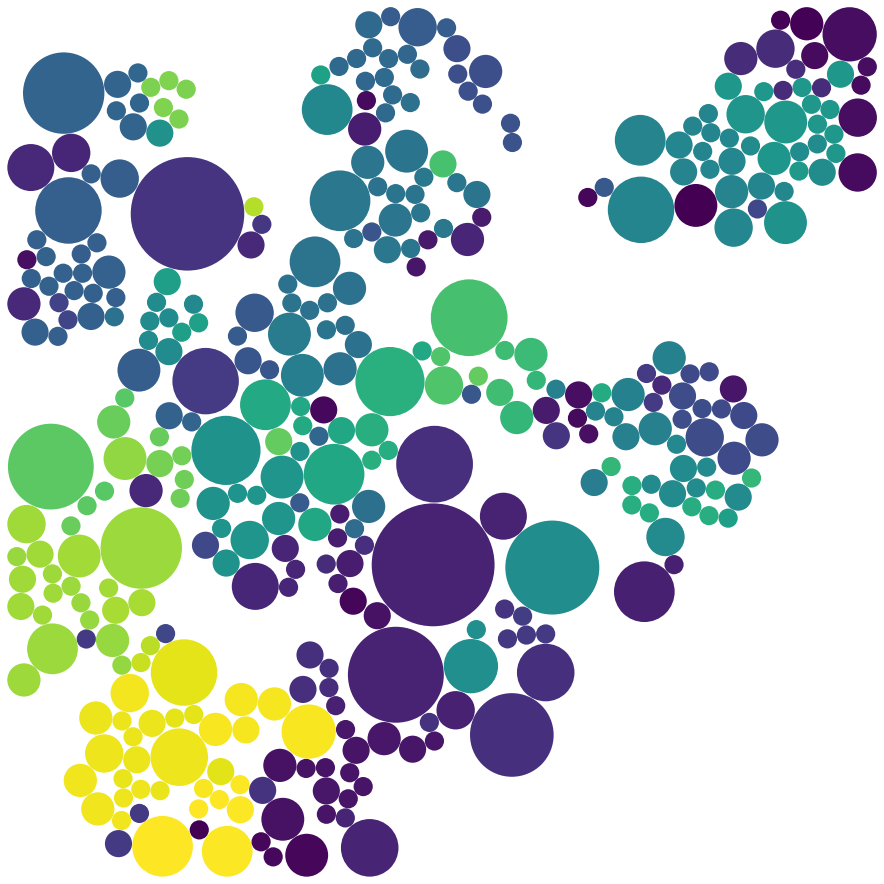

In [33]:
cmap = mpl.cm.get_cmap('viridis')

plt.figure(figsize=(16,16))
ax = plt.gca()
for emb, n in zip(embedding, P_nodes):
    ax.add_patch(plt.Circle(emb.tolist(), np.sqrt(n.pred) * f, fc=cmap(color[n]))) # ec="white"
#     if n.pred > np.quantile(weights, 0.8):
#         ax.text(*emb.tolist(), label_name(n.label), verticalalignment='bottom', horizontalalignment='center')
#         ax.text(*emb.tolist(), label_type(n.label), verticalalignment='top', horizontalalignment='center')
ax.set_aspect('equal')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis('off')
plt.savefig('bubbles_40.pdf', bbox_inches='tight', pad_inches = 0)
plt.show()

In [ ]:

depths = tree.get_depths()

area_to_colors = []
for d in range(len(depths)):
    area_to_color = {n: [] for n in P_nodes}
    V_d = depths[d]
    for i, v in enumerate(V_d):
        Rv = v.preds
        for l in Rv:
            area_to_color[l].append(i)
    k = len(V_d)
    for key,value in area_to_color.items():
        if len(value) == 0:
            value.append(k)
            k+=1
    area_to_colors.append(area_to_color)

# ------- COMPUTE VORONOI --------
points = MultiPoint(embedding.tolist())

regions = voronoi_diagram(points)

min_x = -1
min_y = -1
max_x = 1
max_y = 1
box = Polygon([[min_x, min_y], [min_x, max_y], [max_x, max_y], [max_x, min_y]])

P_to_region = {}
for i, node in enumerate(P_nodes):
    coord = embedding[i]
    p = Point(*coord)
    found = False
    for region in regions:
        if region.contains(p):
            assert not found
            found = True
            P_to_region[node] = region

# ------- PLOT --------

def path(coords):
    svg = "M" + "L".join([str(px) + "," + str(py) for px,py in coords]) + "Z" # could do coords[:-1] I think
    return svg

depth_choices = [len(depths)-1]#range(len(depths))#[0,1,2,3,4,5,10,15,20]
figs = []
for subplot_i, d in enumerate(depth_choices):
    fig = go.Figure()

    # Update axes properties
    fig.update_xaxes(
        showticklabels=False,
        showgrid=False,
        zeroline=False,
    )

    fig.update_yaxes(
        showticklabels=False,
        showgrid=False,
        zeroline=False,
        scaleanchor = "x",
        scaleratio = 1,
    )

    shapes = []
    colors = plotly.colors.sample_colorscale(colorscale='Turbo', samplepoints=k)
    np.random.shuffle(colors)
    for i, node_with_pred in enumerate(P_nodes):
        region = P_to_region[node_with_pred]
        poly = region.intersection(box)
        polygon = [p for p in poly.exterior.coords]
    #     print(polygon)
    #     plt.fill(*zip(*polygon), alpha=0.4)

        assignments = area_to_colors[d][node_with_pred]
        color = colors[np.random.choice(assignments).item()]
        shapes.append(
            dict(
                type="path",
                path=path(polygon),
                fillcolor=color,
                line_color=color,
            )
        )


    # Add shapes
    fig.update_layout(
        shapes=shapes,
        xaxis_range=[-1,1],
        yaxis_range=[-1,1],
        hovermode="closest",
        height=1000, width=1000
    )
    
    for emb, n in zip(embedding, P_nodes):
        fig.add_annotation(
            x=emb[0],
            y=emb[1],
            text=label_name(n.label),
            showarrow=False,
            yshift=10
        )
        fig.add_annotation(
            x=emb[0],
            y=emb[1],
            text=label_type(n.label),
            showarrow=False,
            yshift=-10
        )
#         ax.text(*emb.tolist(), label_name(n.label), verticalalignment='bottom', horizontalalignment='center')
#         ax.text(*emb.tolist(), label_type(n.label), verticalalignment='top', horizontalalignment='center')
#     ax.set_aspect('equal')
#     plt.xlim(-1, 1)
#     plt.ylim(-1, 1)
#     plt.show()

    figs.append(fig)

for depth, fig in zip(depth_choices, figs):
    print("Depth of ", depth)
    fig.show()

In [ ]:
from visualize_events import HexMerge
alg = HexMerge()

alg.fit(tree)
fig = alg.make_fig()

In [ ]:
import matplotlib.pyplot as plt
fig = voronoi_plot_2d(vor)
plt.show()


# Design 2

In [ ]:
full_tree = T

tree = summary.copy()
tree.reset_pred()
tree.descendant_pred()
tree.attr_label()

T.attr_label()

N = None

# cmap = mpl.cm.get_cmap('viridis')
# cmap = px.colors.sequential.Viridis
for i, node in enumerate(full_tree.traverse(raise_on_visited=False, yield_visited=False, yield_first_visit=True)):
    coloring[node.name] = i / (len(full_tree) - 1)

nodes = None
sum_pred = full_tree.root.pred_agg

indx_P_nodes, P_nodes = [], []
for i, node in enumerate(full_tree.nodes.values()):
    if (node.pred is not None and node.pred != 0):
        indx_P_nodes.append(i)
        P_nodes.append(node)
P_N = len(P_nodes)

depths = tree.get_depths()

P_nodes_names = [n.name for n in P_nodes]
total_P = None

def comp_coords(assignment):
    x_last = 0
    x_partition = [x_last]
    for assigned in assignment:
        pred = P_nodes[assigned].pred
        x_last += pred / sum_pred
        x_partition.append(x_last)
    assert abs(x_partition[-1] - 1) < 1e-6
    return x_partition

P_nodes_color = [coloring[node.name] for node in P_nodes]
assignment = np.argsort(P_nodes_color)
# assignment = np.arange(P_N)
assert len(assignment == P_N)


nodes_in_tree = set(list(tree.nodes.keys()))

def local_cost(i):
    cost = 0
    P_node = P_nodes[assignment[i]]
    ancs_a = set(list(P_node.ancestors()))
    if i > 0:
        P_node_left = P_nodes[assignment[i-1]]
        ancs_b = set(list(P_node_left.ancestors()))
        diff = [n.name for n in ancs_a.symmetric_difference(ancs_b) if n.name in nodes_in_tree]
        cost -= len(diff)
        
    if i < P_N - 1:
        P_node_right = P_nodes[assignment[i+1]]
        ancs_b = set(list(P_node_right.ancestors()))
        diff = [n.name for n in ancs_a.symmetric_difference(ancs_b) if n.name in nodes_in_tree]
        cost -= len(diff)
    
    return cost

def local_change(i, j):
    cost_now = local_cost(i) + local_cost(j)

    temp = assignment[i]
    assignment[i] = assignment[j]
    assignment[j] = temp
    
    cost_then = local_cost(i) + local_cost(j)
    
    temp = assignment[i]
    assignment[i] = assignment[j]
    assignment[j] = temp
    
    return cost_then - cost_now

def cost(assignment):
    inverse_assignment = {P_nodes[j].name: i for i, j in enumerate(assignment)}
    cost = 0.
    for node in tree.nodes.values():
        to_draw = np.zeros(P_N+1, dtype=bool)
        full_tree_node = full_tree.nodes[node.name]
        for pred in full_tree_node.preds:
            if pred.name in P_nodes_names:
                block = inverse_assignment[pred.name]
                to_draw[block] = True
        last_draw_here = None
        time_since_last_draw = 0
        for draw_here in to_draw:
            if draw_here:
                if last_draw_here is not None:
                    cost += 1 + time_since_last_draw
                last_draw_here = draw_here
                time_since_last_draw = 0
            time_since_last_draw += 1
    return - cost

best = cost(assignment)

Nchanged = 0

for i in range(1, P_N - 1):
    rel_cost = np.zeros(P_N)
    for j in range(i+1, P_N):
        rel_cost[j] = local_change(i, j)
    if np.min(rel_cost) != 0:
        j = np.argmin(rel_cost)
    else:
        continue
    temp = assignment[i]
    assignment[i] = assignment[j]
    assignment[j] = temp

for _ in range(1000):
    i, j = np.random.choice(P_N, size=2, replace=False).tolist()
    changed = local_change(i, j) < 0
#     print(changed)
    if changed:
        Nchanged += 1
        temp = assignment[i]
        assignment[i] = assignment[j]
        assignment[j] = temp
#         assert cost(assignment) < best
#     else:
#         assert cost(assignment) == best
#     np.random.shuffle(assignment)
#     new_cost = cost(assignment)
#     if new_cost < best:
#         best = new_cost
#         best_assignment = assignment.copy()

inverse_assignment = {P_nodes[j].name: i for i, j in enumerate(assignment)}
x_partition = comp_coords(assignment)
    
fig = go.Figure()

# Update axes properties
fig.update_xaxes(
    showticklabels=False,
    showgrid=False,
    zeroline=False,
    range=[0, 1],
    fixedrange=True
)

fig.update_yaxes(
    showticklabels=False,
    showgrid=False,
    zeroline=False,
#     scaleanchor = "x",
#     scaleratio = 1,
#     range=[y_min - radius, y_max + radius]
)

def add_row(node, y=None, y_bottom=None, opacity=1., text=True):
    to_draw = np.zeros(P_N+1, dtype=bool)
    if y_bottom is None:
        y_bottom = y - (1/len(tree.nodes))
    full_tree_node = full_tree.nodes[node.name]
    for pred in full_tree_node.preds:
        if pred.name in P_nodes_names:
            block = inverse_assignment[pred.name]
            to_draw[block] = True
    x_coords, y_coords = [], []
    prev = False
    for i, draw_here in enumerate(to_draw):
        if prev == False and draw_here == True:
            if len(x_coords) > 0:
                x_coords.append(None)
                y_coords.append(None)
            x_coords.append(x_partition[i])
            x_coords.append(x_partition[i])
            y_coords.append(y)
            y_coords.append(y_bottom)
        elif prev == True and draw_here == False:
            x_coords.append(x_partition[i])
            x_coords.append(x_partition[i])
            y_coords.append(y_bottom)
            y_coords.append(y)

            x_coords.append(x_coords[len(x_coords) - 4])
            y_coords.append(y_coords[len(y_coords) - 4])
        prev = draw_here
    if text == False:
        text = ''
    else:
        text = [node.label] + ['' for _ in range(len(x_coords) - 1)]
    fig.add_trace(go.Scatter(x=x_coords, y=y_coords, fill="toself", opacity=opacity,
                             mode="text", marker={'color':coloring[node.name], 'colorscale':"Viridis"}, textposition="bottom right",
                             text=text, visible=True)) # mode="lines"
#     print(any(e for e in to_draw))

    # modes: none, lines, text, markers
P_N_in_tree = [n for n in tree.nodes.values() if not (n.pred is None or n.pred == 0.)]
y = - (len(tree.nodes) - len(P_N_in_tree)) / len(tree.nodes)
# y = - (len(nodes) - P_N_in_tree) / len(nodes)
for V_d in depths:
    for node in V_d:
        if not (node.pred is None or node.pred == 0.):
            add_row(node, y=0, y_bottom=min(y*1.2, y-1/len(tree.nodes)), opacity=0.1, text=False)
            add_row(node, y=y, y_bottom=min(y*1.2, y-1/len(tree.nodes)))

y = 0
for V_d in depths:
    for node in V_d:
        if node.pred is None or node.pred == 0.:
            add_row(node, y=y)
            y -= 1 / len(tree.nodes)
            
config = dict({'scrollZoom': True})
fig.show(config=config)

Nchanged

In [ ]:
np.all(assignment == np.arange(P_N))

In [ ]:
cost(assignment)

# Design 3

In [ ]:
from visualize_events import HexMerge
alg = HexMerge(fraction_occupied_hexes=0.9, distance_factor=0.01, adjacency_factor=0, kmax=0)
alg.fit(tree)
fig = alg.make_fig()

In [ ]:
# A={0,1}x[0,n]x[0,m] -> P
# 2nm places -> P

# nodes_df = pd.DataFrame({'name':[0,1,2,3,4,5],'label':[0,1,2,3,4,5]}).set_index('name')
# edges_df = pd.DataFrame({'parent':[0, 0, 0, 1, 2, 3,1],'child':[1, 2, 3, 4, 4, 4,5]})
# diamond_tail = DAG(nodes_df, edges_df)
# predictions = pd.Series([1, 1], index=[4, 5])
# t = diamond_tail.set_predictions(predictions)

# ---------- PARAMS
t = C

target_hexes = 1000
kmax = 0
same_leaf_factor = 1
adjacency_factor = 1
distance_factor = 100
hexes_scaling = lambda x : x
temperature = lambda k, kmax: (1 - (k)/kmax) ** 2 / 20 #.1/np.exp(k / 100).item()
acceptance_function = lambda cost_diff, T, rv: cost_diff < 0 or np.exp((-cost_diff+0.01)/T) >= rv
quantile = .0
moved_running_avg_window = 10000
MOVED_LOWERBOUND = 0.03
# hexes_scaling = lambda x : 1 + np.sqrt(x).item() # PARAM.


# ---------- PLOTTING PARAMS
angle = - np.pi / 6
radius = 1/np.sqrt(3)
angles = np.array([angle + k * (np.pi/3) for k in range(6)])
x_hex = radius * np.cos(angles)
y_hex = radius * np.sin(angles)
x_width = np.amax(x_hex) - np.amin(x_hex)
y_width = np.amax(y_hex) - np.amin(y_hex)

def center(row, col):
    cx = (col * radius * 1.5)
    cy = np.sqrt(3) * row
    if col % 2 == 1:
        cy = cy + np.sqrt(3) * 0.5
    return cx, cy

def cartesian(a, r, c):
    return (
        a/2 + c,
        np.sqrt(3) * (a/2 + r)
    )



n = int(np.sqrt(target_hexes) // 2)
m = int(np.sqrt(target_hexes))
assert 2 * n * m <= target_hexes

scaled = [hexes_scaling(P_node.pred) for P_node in t.nodes.values() if P_node.pred is not None]
sum_scaled = sum(scaled)
to_place = []

nodes = list(t.nodes.values())
N = len(t)
indx_P_nodes, P_nodes = [], []
for i, node in enumerate(nodes):
    if (node.pred is not None and node.pred != 0):
        hexes = int(np.floor(hexes_scaling(node.pred) / sum_scaled * (2*n*m)).item())
        if hexes <= 0:
            continue
        indx_P_nodes.append(i)
        P_nodes.append(node)
        for _ in range(hexes):
            to_place.append(len(P_nodes) - 1)
P_N = len(P_nodes)


# to_place = [i for i, P_node in enumerate(P_nodes) for _ in range(int(np.floor(scaled[i] / sum_scaled * (2*n*m)).item()))]

assert 2 * n * m >= len(to_place)

t.add_parent_store()
from itertools import combinations
t.descendant_pred()
pred_nodes = t.root.preds
weights = dict()
for node in t.nodes.values():
    if node is t.root:
        continue
    significant_preds = [pred for pred in node.preds if pred in P_nodes]
    for a, b in combinations(significant_preds, 2):
        if a == b:
            assert False
        if id(a) > id(b):
            a, b = b, a
        w = weights.get((a, b), 0)
        weights[(a, b)] = w + 1 * node.depth

total_weight = sum(weights.values())

for k, v in weights.items():
    weights[k] = (v / total_weight) * adjacency_factor

# weight all adjacencies and all transitive stuff the same    
for P_node in P_nodes:
    weights[(P_node, P_node)] = same_leaf_factor / P_N

node_to_idx = {node: i for i, node in enumerate(P_nodes)}
new_weights = dict()
for k, v in weights.items():
    n1, n2 = k
    n1, n2 = node_to_idx[n1], node_to_idx[n2]
    new_weights[(n1, n2)] = v

weights = new_weights

# ------- DESIRED LOCATION --------
anc_store = t.get_ancestors()

dist = np.zeros((N, N))
for i, anc1 in enumerate(anc_store):
    for j, anc2 in enumerate(anc_store[i+1:], i+1):
#         common = anc1.intersection(anc2)
        diff = anc1.symmetric_difference(anc2)
        #d = 1/len(common)
#         d = 1/(sum(a.depth for a in common)+1)
        d = len(diff) / (len(anc1) + len(anc2))
        dist[i, j] = d
        dist[j, i] = d

similarity = dist[indx_P_nodes, :][:, indx_P_nodes]

tsne = TSNE(metric="precomputed",
            perplexity=30,
            early_exaggeration=10)
embedding = tsne.fit_transform(similarity)

x_min, y_min = cartesian(0, 0, 0)
x_max, y_max = cartesian(1, n, m)
# TODO might need to offset
x_scaler = MinMaxScaler(feature_range=(x_min,x_max))
y_scaler = MinMaxScaler(feature_range=(y_min,y_max))
embedding[:, 0] = x_scaler.fit_transform(embedding[:, 0].reshape(-1, 1)).reshape(-1)
embedding[:, 1] = y_scaler.fit_transform(embedding[:, 1].reshape(-1, 1)).reshape(-1)

# to_01_scaler = MinMaxScaler(feature_range=(0,1)).fit(embedding) # distorts distances because figure does not have asp ratio of 1

def neighbors(a, r, c):
    # interesting fact: if a and b are neighbors, and a is the x-th neighbor of b, then b is the (x+3%6)-th neighbor of a
    return (
        (a, r, (c+1) % m),
        (1-a, (r-(1-a)) % n, (c+a) % m),
        (1-a, (r-(1-a)) % n, (c-(1-a)) % m),
        (a, r, (c-1) % m),
        (1-a, (r+a) % n, (c-(1-a)) % m),
        (1-a, (r+a) % n, (c+a) % m)
    )

def cost(assignment):
    cost_matrix_adj = np.zeros((2, n, m, 6))
    it = np.nditer(assignment, flags=['multi_index'])
    for x in it:
        if x < 0:
            continue
        for neighbor_idx, neighbor in enumerate(neighbors(*it.multi_index)): # can make more eff due to symmetry 
            y = assignment[neighbor]
            if y < 0:
                continue
            w = weights.get((x.item(), y), 0)
            if w == 0:
                w = weights.get((y, x.item()), 0) # only one will exist atm
            if w != 0:
                cost_matrix_adj[(*it.multi_index, neighbor_idx)] = -w
    
    cost_matrix_dis = np.zeros((2, n, m))
    it = np.nditer(assignment, flags=['multi_index'])
    for x in it:
        if x < 0:
            continue
        tile_x, tile_y = cartesian(*it.multi_index)
        xx, xy = embedding[x].tolist()
        d = ((xx - tile_x)/(2*n-1)) ** 2 + ((xy - tile_y)/(m-1)) ** 2
        cost_matrix_dis[it.multi_index] = d
    cost_matrix_dis *= distance_factor

    cost_matrix_adj_sum = np.sum(cost_matrix_adj, axis=3)
    cost_agg = np.sum(cost_matrix_adj_sum) + np.sum(cost_matrix_dis)
    return cost_agg, cost_matrix_adj, cost_matrix_adj_sum, cost_matrix_dis

# def random_neighbor(s):
#     # SWITCHEROO
# #     x = np.random.choice(2), np.random.choice(n), np.random.choice(m)
# #     y = neighbors(*x)[np.random.choice(3)]
# #     s_new = s.copy()
# #     s_new[x], s_new[y] = s_new[y], s_new[x]
#     # RANDOM ASSIGNMENT
#     s_new = s.copy()
#     x = np.random.choice(2), np.random.choice(n), np.random.choice(m)
#     s_new[x] = np.random.choice(P_N+1) - 1
#     return s_new
     
# s = np.random.choice(P_N, replace=True, size=(2, n, m))

def cost_x(s, x):
    assignment = s[x]
    if assignment < 0:
        return [0] * 6, 0
    new_cost_x_neighbors = []
    for neighbor in neighbors(*x):
        neighbor_assignment = s[neighbor]
        if neighbor_assignment < 0:
            w = 0
        else:
            w = weights.get((assignment, neighbor_assignment), 0)
            if w == 0:
                w = weights.get((neighbor_assignment, assignment), 0)
        new_cost_x_neighbors.append(-w)

    xx, xy = cartesian(*x)
    yx, yy = embedding[assignment].tolist()
    d = ((xx - yx)/(2*n-1)) ** 2 + ((xy - yy)/(m-1)) ** 2
    d *= distance_factor
    return new_cost_x_neighbors, d

def set_cost_x(s, cost_matrix, cost_matrix_sum, x, cost_neighbors_x):
    # own
    cost_matrix[x] = cost_neighbors_x
    cost_matrix_sum[x] = np.sum(cost_matrix[x])
    # others'
    for neighbor_idx, neighbor in enumerate(neighbors(*x)):
        self_idx = (neighbor_idx + 3) % 6
        cost_matrix[(*neighbor, self_idx)] = cost_neighbors_x[neighbor_idx]
        cost_matrix_sum[neighbor] = np.sum(cost_matrix[neighbor])

def random_grid_point():
    return (np.random.choice(2), np.random.choice(n), np.random.choice(m))

# RANDOM LAYOUT
# for _ in range(2 * n * m - len(to_place)):
#     to_place.append(-1)
# s = np.array(to_place)
# np.random.shuffle(s)
# s = s.reshape(2, n, m)

# TODO better initialization - Greedy?
np.random.shuffle(to_place)
s = np.ones((2, n, m), dtype=int) * -1
# maintain a heap of: option -> max. cost reduction

def marginal_cost(s, x, assign):
    assert s[x] < 0
    s[x] = assign
    new_cost_x_neighbors, distance_cost = cost_x(s, x)
    marginal = 2 * sum(new_cost_x_neighbors) + distance_cost
    s[x] = -1
    return marginal

to_place_set = set(to_place)
options = np.zeros((2, n, m, P_N))
for a in (0,1):
    for r in range(n):
        for c in range(m):
            for assign in to_place_set:
                options[a, r, c, assign] = (
                    marginal_cost(s, (a, r, c), assign)
                )

to_place_still = {assign: to_place.count(assign) for assign in to_place_set}
to_place_still_total = len(to_place)
while to_place_still_total > 0:
    a, r, c, assign = np.unravel_index(np.argmin(options, axis=None), options.shape)
    s[(a, r, c)] = assign
    options[a, r, c, :] = np.infty
    to_place_still[assign] -= 1
    to_place_still_total -= 1
    if to_place_still_total == 0:
        break
    if to_place_still[assign] == 0:
        options[:, :, :, assign] = np.infty
        to_place_set.remove(assign)
    for neighbor in neighbors(a, r, c):
        if s[neighbor] < 0:
            for assign in to_place_set:
                if options[a, r, c, assign] != np.infty:
                    options[a, r, c, assign] = (
                        marginal_cost(s, (a, r, c), assign)
                    )  
                    
cost_s, cost_matrix_s, cost_matrix_s_sum, cost_matrix_s_distances = cost(s)
moved = 0
moved_running_avg = 0.
movable_points = None
for k in range(kmax):
    if k%1000==0:
        print(f"Cost: {np.sum(cost_matrix_s_sum) + np.sum(cost_matrix_s_distances)}. Running average % moved: {moved_running_avg}")
    T = temperature(k, kmax)
    # random neighbor testing
    if k % 10 == 0:
        moveable_points = np.arange(2*n*m)[cost_matrix_s_sum.reshape(-1) >= np.quantile(cost_matrix_s_sum, quantile)]
    x, y = np.random.choice(moveable_points, replace=False, size=2).tolist()
    x = (x//(n*m), (x//m)%n, x%m)
    y = (y//(n*m), (y//m)%n, y%m)
    if x == y: continue
    #
    old_assignment_x = s[x]
    old_assignment_y = s[y]
    old_cost_x = np.sum(cost_matrix_s[x]) + cost_matrix_s_distances[x]
    old_cost_y = np.sum(cost_matrix_s[y]) + cost_matrix_s_distances[y]
    
#     new_assignment = np.random.choice(P_N+1) - 1 # random choice of neighbor (different color in that hex)
    s[x], s[y] = old_assignment_y, old_assignment_x
    new_cost_x_neighbors, distance_cost_x = cost_x(s, x)
    new_cost_y_neighbors, distance_cost_y = cost_x(s, y)
    
    cost_diff = 2 * (
        sum(new_cost_x_neighbors) + distance_cost_x - old_cost_x
        + sum(new_cost_y_neighbors) + distance_cost_y - old_cost_y
    ) # times TWO because of double counting adjacency TODO half_neighbors?
    acceptance = acceptance_function(cost_diff, T, np.random.uniform())
    if acceptance:
        moved += 1
        just_moved = True
        set_cost_x(s, cost_matrix_s, cost_matrix_s_sum, x, new_cost_x_neighbors)
        set_cost_x(s, cost_matrix_s, cost_matrix_s_sum, y, new_cost_y_neighbors)
        cost_matrix_s_distances[x] = distance_cost_x
        cost_matrix_s_distances[y] = distance_cost_y
    else:
        just_moved = False
        s[x] = old_assignment_x
        s[y] = old_assignment_y
#     print(x, y)
    moved_running_avg = (
        (min(moved_running_avg_window-1, k) * moved_running_avg + just_moved)
        /min(moved_running_avg_window, k+1)
    )
    if moved_running_avg <= MOVED_LOWERBOUND and k > moved_running_avg_window:
        print(f"Early stop at k={k}")
        break
#     calc = cost(s)
#     assert (cost_matrix_s == calc[1]).all()
#     assert (cost_matrix_s_sum == calc[2]).all()
#     assert (cost_matrix_s_distances == calc[3]).all()
print(f"Moved {moved} out of {k} iters")

# PSEUDOCODE sim annealing
# Let s = s0
# For k = 0 through kmax (exclusive):

#     T ← temperature( 1 - (k+1)/kmax )
#     Pick a random neighbour, snew ← neighbour(s)
#     If P(E(s), E(snew), T) ≥ random(0, 1):
#         s ← snew

# Output: the final state 

assignment = s

# locations = [center(i, j) for i in range(10) for j in range(10)]

def svg_path(xc, yc, radius_modifier = 1.):
    return "M" + "L".join([str(px) + "," + str(py) for px,py in zip(xc + x_hex * radius_modifier, yc + y_hex * radius_modifier)]) + "Z"

def path(xc, yc, radius_modifier = 1.):
    x_coords = (xc + x_hex * radius_modifier).tolist()
    x_coords.append(x_coords[0])
    y_coords = (yc + y_hex * radius_modifier).tolist()
    y_coords.append(y_coords[0])
    return x_coords, y_coords


P_nodes_to_grid = {P_node: [] for P_node in P_nodes}

it = np.nditer(assignment, flags=['multi_index'])
for x in it:
    if x >= 0:
        P_nodes_to_grid[P_nodes[x]].append(it.multi_index)

t.attr_label()
depths = t.get_depths()    

colors_required = P_N + max(len(V_d) for V_d in depths)

colors = plotly.colors.sample_colorscale(colorscale='Turbo', samplepoints=colors_required)
np.random.shuffle(colors)

# max_pred = max([P_node.pred for P_node in P_nodes])


In [ ]:
np.random.shuffle(colors)
fig = go.Figure()

# Update axes properties
fig.update_xaxes(
    showticklabels=False,
    showgrid=False,
    zeroline=False,
    range=[x_min - radius, x_max + radius]
)

fig.update_yaxes(
    showticklabels=False,
    showgrid=False,
    zeroline=False,
    scaleanchor = "x",
    scaleratio = 1,
    range=[y_min - radius, y_max + radius]
)

# ------- CREATE CONSTRAINTS --------
P_node_to_color = {P_node: color for P_node, color in zip(P_nodes, colors)} # shouldn't matter that colors is longer
d_P_node_occupancy = [{P_node: [] for P_node in P_nodes} for _ in depths]
v_to_color = dict()
for d in range(len(depths)):
    V_d = depths[d]
    # matrix of shape (V_d)
    # largest colors maintain.
    area_coverage = np.zeros(len(V_d))
    for i, v in enumerate(V_d):
        Rv = [pred for pred in v.preds if pred in P_nodes]
        coverage = []
        for P_node in Rv:
            d_P_node_occupancy[d][P_node].append(v)
            coverage += P_nodes_to_grid[P_node]
        area_coverage[i] = len(set(coverage))
    indxs = np.flip(np.argsort(area_coverage))
    
    remaining_colors = set(colors)
    for indx in indxs:
        v = V_d[indx]
        Rv = [pred for pred in v.preds if pred in P_nodes]
        max_col = -1
        max_size = -1
        for P_node in Rv:
            size = len(P_nodes_to_grid[P_node])
            col = P_node_to_color[P_node]
            if size > max_size and col in remaining_colors:
                max_size = size
                max_col = col
        if max_col == -1:
            max_col = remaining_colors.pop()
        else:
            remaining_colors.remove(max_col)
        v_color = max_col
        v_to_color[v] = v_color



disc = 100000
def simplify_grid_coords(grid_coords):
#     edges = [
#         grid_coord for grid_coord in grid_coords if not all(
#             neighbor in grid_coords for neighbor in neighbors(*grid_coord)
#         )
#     ]
#     while len(edges) != 0
    segments = dict()
    for grid_coord in grid_coords:
        cart = cartesian(*grid_coord)
        x_coords, y_coords = path(*cart)
        for i, neigh in enumerate(neighbors(*grid_coord)):
            if neigh not in grid_coords:
                x1, x2 = x_coords[i:i+2]
                y1, y2 = y_coords[i:i+2]
                x1 = int(round(x1 * disc))
                x2 = int(round(x2 * disc))
                y1 = int(round(y1 * disc))
                y2 = int(round(y2 * disc))
                adj = segments.get((x1, y1), [])
                adj.append((x2, y2))
                segments[(x1, y1)] = adj
    
    prev_point = list(segments.keys())[0]
    cycles = []
    current_cycle = [prev_point]
    while True:
        next_points = segments.get(prev_point, None)
        if next_points is None:
            cycles.append(current_cycle)
            if len(segments) == 0:
                break
            prev_point = list(segments.keys())[0]
            current_cycle = []
        elif len(next_points) == 1:
            del segments[prev_point]
            prev_point = next_points[0]
        else:
            prev_point = next_points.pop() # it matters which we pop!?
        
        current_cycle.append(prev_point)
    x_coord, y_coord = [], []
    for i, cycle in enumerate(cycles):
        if i > 0:
            x_coord.append(None)
            y_coord.append(None)
        for x_co, y_co in cycle:
            x_coord.append(x_co / disc)
            y_coord.append(y_co / disc)
    return x_coord, y_coord

v_to_trace = dict()
for d, V_d in enumerate(depths):
    for v in V_d:
        Rv = [pred for pred in v.preds if pred in P_nodes]
        x_coords = []
        y_coords = []
        for P_node in Rv:
#     color = colors[node_colors[0]]
            occupancy = d_P_node_occupancy[d][P_node]
            order = occupancy.index(v)
            radius = 1 - (order / len(occupancy))
            if radius < 1:
                continue
            for j, grid_coord in enumerate(P_nodes_to_grid[P_node]):
                if j > 0:
                    x_coords.append(None)
                    y_coords.append(None)
                location = cartesian(*grid_coord)
                x_coord, y_coord = path(*location, radius_modifier = radius)
#                 if len(occupancy) == 1:
#                     pass
#                 elif len(occupancy) in [2, 3]:
#                     slices = len(occupancy)
#                     slice_size = 6 // len(occupancy)
#                     idx = order * slice_size
#                     x_coord = x_coord[idx:idx + slice_size+1]
#                     y_coord = y_coord[idx:idx + slice_size+1]
#                     x_coord.append(location[0])
#                     y_coord.append(location[1])
#                     x_coord.append(x_coord[0])
#                     y_coord.append(y_coord[0])
#                 else:
#                     raise ValueError("hi")
                x_coords.extend(x_coord)
                y_coords.extend(y_coord)
        v_to_trace[v] = len(fig.data)
        fig.add_trace(go.Scatter(x=x_coords, y=y_coords, fill="toself", mode="text", fillcolor=v_to_color[v], name=v.label, visible=False)) # mode="lines"

nodes_left = sum(len(V_d) for V_d in depths)
nodes_seen = 0  
steps = []
for d, V_d in enumerate(depths):
    nodes_this_layer = len(V_d)
    nodes_left -= nodes_this_layer
    visible = [False] * nodes_seen + [True] * nodes_this_layer + [False] * nodes_left
    nodes_seen += nodes_this_layer
    for P_node in P_nodes:
        if P_node.depth < d:
            visible[v_to_trace[P_node]] = True

    step = dict(
        method="update",
        args=[{"visible": visible},
              {"title": "Depth: " + str(d)}],  # layout attribute
    )
    steps.append(step)
        
sliders = [dict(
    active=len(depths) - 1,
    currentvalue={"prefix": "Depth: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=-0.99
    )
)

config = {'responsive': False}

# go.FigureWidget(data=fig)

fig.show(config=config)


In [ ]:
t = C
t.descendant_pred()
t.add_parent_store()
t.aggregate_pred(aggregate='sum')
t.attr_label()

nodes = list(t.nodes.values())
sum_pred = sum(n.pred for n in nodes if n.pred is not None)
N = len(t)
indx_P_nodes, P_nodes = [], []
for i, node in enumerate(nodes):
    if (node.pred is not None and node.pred != 0):
        if node.pred > sum_pred / 100: # only significant stuff
            indx_P_nodes.append(i)
            P_nodes.append(node)
P_N = len(P_nodes)

depths = t.get_depths()

colors = plotly.colors.sample_colorscale(colorscale='Turbo', samplepoints=P_N)
P_node_to_color = {P_node: colors[i] for i, P_node in enumerate(P_nodes)}

node_to_color = {}
for node in nodes:
    desc_preds = node.preds
    sum_preds = sum(desc.pred for desc in desc_preds)
    rgb = 0.
    for desc in desc_preds:
        desc_color = np.array([x for x in map(int, re.findall(r'\d+', P_node_to_color[desc]))])
        rgb += (1/len(desc_preds)) * np.square(desc_color)
    node_to_color[node] = 'rgb(' + ','.join([str(x) for x in np.sqrt(rgb)]) + ')'
#     max_pred = -1
#     desc = -1
#     for desc_pred in desc_preds:
#         if desc_pred.pred > max_pred:
#             max_pred = desc_pred.pred
#             desc = desc_pred
#     node_to_color[node] = P_node_to_color[desc]

source, target, value, color = [], [], [], []

node_to_index = {node: i for i, node in enumerate(nodes)}
for i, n in enumerate(nodes):
    for c in n.children:
        source.append(i)
        target.append(node_to_index[c])
        width = c.pred_agg
        width /= len(c.parents)
        value.append(width)
        color.append(node_to_color[n])

        

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = [n.label for n in nodes],
      color = [node_to_color[n] for n in nodes]
    ),
    link = dict(
      source = source, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = target,
      value = value,
      color = color,
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

In [ ]:
import re
np.array([x for x in map(int, re.findall(r'\d+', colors[0]))])

In [ ]:
embedding = np.array([[0,0],[0,1],[1,1]])
N_points = len(embedding)
# move points away from eachother
pw = pairwise_distances(embedding)
for i in range(N_points):
    pw[i,i] = np.inf
indx = (pw == 0).nonzero()
for i, j in zip(*indx):
    pw[i,j] = np.inf
F = np.divide(0.1, pw * pw)
assert F.shape == pw.shape 
move = np.tile(embedding.reshape(N_points, 1, 2), (1, N_points, 1)) - np.tile(embedding.reshape(1, N_points, 2), (N_points, 1, 1))
displacement = np.tile(F.reshape(N_points, N_points, 1), (1, 1, 2)) * move
new = embedding + np.sum(displacement, axis=1)
print(embedding)
print(new)

In [ ]:
np.isnan(new).any()

In [ ]:
embedding[[44, 130]]

In [ ]:
embedding

In [ ]:
plt.scatter(x=embedding[:, 0], y = embedding[:, 1])
for i, lab in enumerate([n.label for n in P_nodes]):
    plt.annotate(lab, (embedding[i, 0], embedding[i, 1]))

In [ ]:
similarity

In [ ]:
regions[0]


In [ ]:


min_x = -max_norm_embedding
min_y = -max_norm_embedding
max_x = max_norm_embedding
max_y = max_norm_embedding
box = Polygon([[min_x, min_y], [min_x, max_y], [max_x, max_y], [max_x, min_y]])

# colorize
for region in regions:
#     polygon = vertices[region]
    # Clipping polygon
#     poly = Polygon(polygon)
    poly = region.intersection(box)
    polygon = [p for p in poly.exterior.coords]

    plt.fill(*zip(*polygon), alpha=0.4)

In [ ]:

min_x = -max_norm_embedding
min_y = -max_norm_embedding
max_x = max_norm_embedding
max_y = max_norm_embedding
box = Polygon([[min_x, min_y], [min_x, max_y], [max_x, max_y], [max_x, min_y]])

# VORONOI COMPUTE
points = MultiPoint(embedding.tolist())

regions = voronoi_diagram(points, envelope=box)

# colorize
for region in regions:
#     polygon = vertices[region]
    # Clipping polygon
#     poly = Polygon(polygon)
    poly = region.intersection(box)
    polygon = [p for p in poly.exterior.coords]
    plt.fill(*zip(*polygon))


In [ ]:
# colorize
for region in regions:
#     polygon = vertices[region]
    # Clipping polygon
#     poly = Polygon(polygon)
    poly = region.intersection(box)
    polygon = [p for p in poly.exterior.coords]
    plt.fill(*zip(*polygon), alpha=0.4)


In [ ]:
F_edge = np.zeros(embedding.shape)
magnitude = np.linalg.norm(embedding, ord=5, axis=1)
F_edge[:, 0] = (-embedding[:, 0]) * magnitude
F_edge[:, 1] = (-embedding[:, 1]) * magnitude

In [ ]:
np.mean(np.linalg.norm(F_edge, axis=1))

In [ ]:
weights = np.array([p.pred for p in P])
cross = weights.reshape(-1, 1)@weights.reshape(1, -1)
weights.shape

In [ ]:
cross = weights.reshape(-1, 1)@weights.reshape(1, -1)

In [ ]:
cross.shape

In [ ]:
cross[5,4] == weights[5] * weights[4]

In [ ]:
test = np.arange(1000).reshape(10, 10, 10)
x = (1, 2)
test[x]


In [ ]:
for x in np.arange(2*n*m)[np.sum(cost_matrix_s, axis=3).reshape(-1) == 0]:
    coord = (x//(n*m), (x//m)%n, x%m)
    print(np.sum(cost_matrix_s, axis=3)[coord])

In [ ]:
cost_matrix_s_sum

In [ ]:
np.unravel_index(np.argmin(cost_matrix_s_sum, axis=None), cost_matrix_s_sum.shape)

In [ ]:
np.sum(options == np.min(options, axis=None))

In [ ]:
x = (dict(a=1))

In [ ]:
del x['a']
x